# Prototype #1

In [1]:
import pandas as pd
import kagglehub
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/world-stock-prices-daily-updating")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\s3phi\.cache\kagglehub\datasets\nelgiriyewithana\world-stock-prices-daily-updating\versions\355


In [3]:
#Load Data in pandas
data_path = path+"\World-Stock-Prices-Dataset.csv"
stockdata = pd.read_csv(data_path)
#Create DataFrame
df = pd.DataFrame(stockdata)

<>:2: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\W'
C:\Users\s3phi\AppData\Local\Temp\ipykernel_13388\4072858615.py:2: SyntaxWarning: invalid escape sequence '\W'
  data_path = path+"\World-Stock-Prices-Dataset.csv"


In [4]:
brands = df["Brand_Name"].unique().tolist() #create a list of all brands in the df

In [5]:
brand_AUSWAHL = brands[39] #Platzhalter für eine spätere Auswahl vom User
brand_AUSWAHL

'google'

In [6]:

#Filter Brand_Name by apple and filter columns by Date, Close, Brand_Name
df_apple = df.loc[df["Brand_Name"] == brand_AUSWAHL, ["Date", "Close", "Brand_Name"]]
display(df_apple)

,Date,Close,Brand_Name
39,2025-05-21 00:00:00-04:00,168.559998,google
59,2025-05-20 00:00:00-04:00,163.979996,google
179,2025-05-19 00:00:00-04:00,166.539993,google
232,2025-05-16 00:00:00-04:00,166.190002,google
262,2025-05-16 00:00:00-04:00,166.190002,google
...,...,...,...
267691,2004-08-25 00:00:00-04:00,2.652653,google
267749,2004-08-24 00:00:00-04:00,2.624374,google
267768,2004-08-23 00:00:00-04:00,2.737738,google
267797,2004-08-20 00:00:00-04:00,2.710460,google


In [7]:
df_apple_preproc = df_apple.rename(columns={"Date": "timestamp", "Close": "target", "Brand_Name": "item_id"})
df_apple_preproc.head(5)

,timestamp,target,item_id
39,2025-05-21 00:00:00-04:00,168.559998,google
59,2025-05-20 00:00:00-04:00,163.979996,google
179,2025-05-19 00:00:00-04:00,166.539993,google
232,2025-05-16 00:00:00-04:00,166.190002,google
262,2025-05-16 00:00:00-04:00,166.190002,google


In [8]:
df_apple_preproc["item_id"] = df_apple_preproc['item_id'].astype("string")
df_apple_preproc["timestamp"] = df_apple_preproc['timestamp'].astype("string")
df_apple_preproc.dtypes

timestamp    string[python]
target              float64
item_id      string[python]
dtype: object

In [9]:
timecut = df_apple_preproc["timestamp"].str.slice(stop=10) #Cut hh:mm:ss and timezone
timecut

39        2025-05-21
59        2025-05-20
179       2025-05-19
232       2025-05-16
262       2025-05-16
             ...    
267691    2004-08-25
267749    2004-08-24
267768    2004-08-23
267797    2004-08-20
267834    2004-08-19
Name: timestamp, Length: 5271, dtype: string

In [10]:
df_apple_preproc["timestamp"] = timecut
df_apple_preproc

,timestamp,target,item_id
39,2025-05-21,168.559998,google
59,2025-05-20,163.979996,google
179,2025-05-19,166.539993,google
232,2025-05-16,166.190002,google
262,2025-05-16,166.190002,google
...,...,...,...
267691,2004-08-25,2.652653,google
267749,2004-08-24,2.624374,google
267768,2004-08-23,2.737738,google
267797,2004-08-20,2.710460,google


In [11]:
df_apple_preproc["timestamp"] = pd.to_datetime(timecut) #convert string into datetime64
df_apple_preproc.dtypes

timestamp    datetime64[ns]
target              float64
item_id      string[python]
dtype: object

In [12]:
df_apple_reordered =  df_apple_preproc[['item_id', 'timestamp', 'target']] #Reordering columns

df_apple_reordered

,item_id,timestamp,target
39,google,2025-05-21,168.559998
59,google,2025-05-20,163.979996
179,google,2025-05-19,166.539993
232,google,2025-05-16,166.190002
262,google,2025-05-16,166.190002
...,...,...,...
267691,google,2004-08-25,2.652653
267749,google,2004-08-24,2.624374
267768,google,2004-08-23,2.737738
267797,google,2004-08-20,2.710460


# Preproccessing in AutoGluon

In [13]:
df_irregular = TimeSeriesDataFrame(
    pd.DataFrame(df_apple_reordered)
)
df_irregular.head(10)

target
item_id timestamp             
google  2025-05-21  168.559998
        2025-05-20  163.979996
        2025-05-19  166.539993
        2025-05-16  166.190002
        2025-05-16  166.190002
        2025-05-15  163.960007
        2025-05-14  165.369995
        2025-05-13  159.529999
        2025-05-12  158.460007
        2025-05-05  164.210007

In [14]:
df_regular = df_irregular.convert_frequency(freq="D")
df_filled = df_regular.fill_missing_values()
df_filled.head(10)

target
item_id timestamp           
google  2004-08-19  2.511011
        2004-08-20  2.710460
        2004-08-21  2.710460
        2004-08-22  2.710460
        2004-08-23  2.737738
        2004-08-24  2.624374
        2004-08-25  2.652653
        2004-08-26  2.700450
        2004-08-27  2.656406
        2004-08-28  2.656406

# Equip Model

In [15]:
data = TimeSeriesDataFrame.from_data_frame(
    df = df_filled,
    id_column="item_id",
    timestamp_column="timestamp"
)
data

target
item_id timestamp             
google  2004-08-19    2.511011
        2004-08-20    2.710460
        2004-08-21    2.710460
        2004-08-22    2.710460
        2004-08-23    2.737738
...                        ...
        2025-05-17  166.190002
        2025-05-18  166.190002
        2025-05-19  166.539993
        2025-05-20  163.979996
        2025-05-21  168.559998

[7581 rows x 1 columns]

In [16]:
prediction_length = 30
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_base",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250522_200821'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       1.23 GB / 15.70 GB (7.8%)
Disk Space Avail:   60.58 GB / 475.50 GB (12.7%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 7551 rows, 1 time series. Median time

	16.41   s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 16.43 s
Best model: Chronos[bolt_base]


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


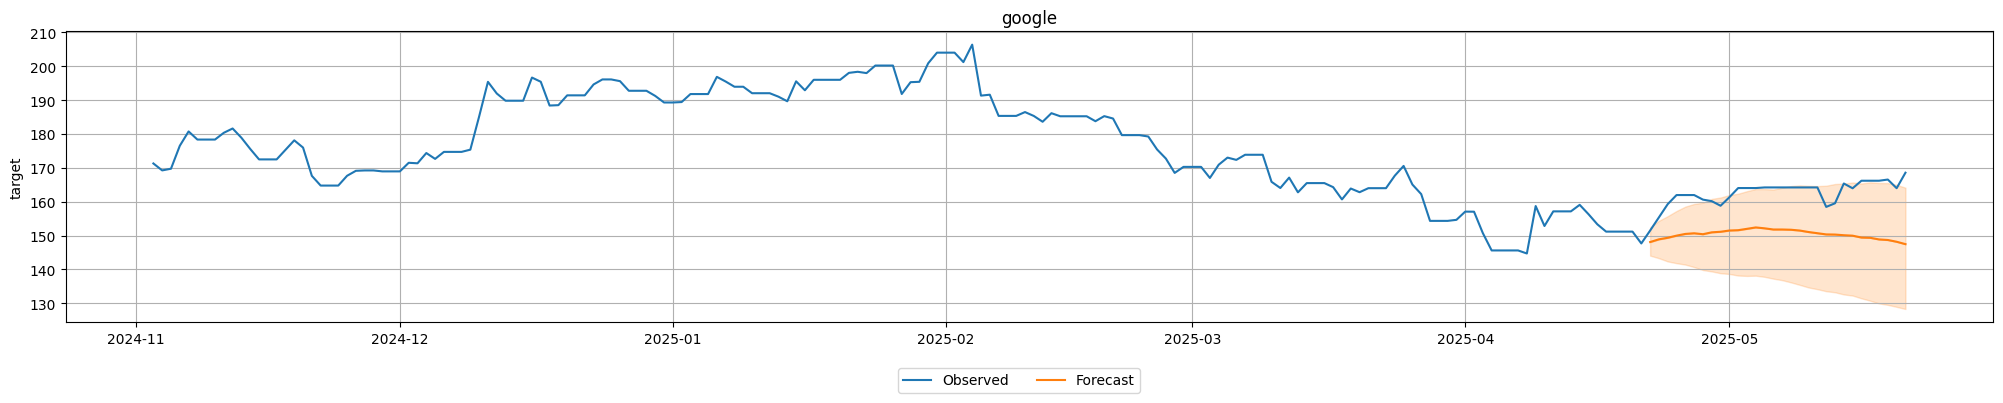

In [17]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);